# 50.040 Natural Language Processing (Fall 2025) Homework 2

**Due 26 October 2025, 23:59 PM**


### STUDNET ID: 1006922
 
### Name: Lim Sherri

### Students with whom you have discussed (if any):

In [1]:
#!pip3 install torch
#!pip3 install d2l
#pip3 install torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
from d2l import torch as d2l

One of the core challenges in NLP is how to represent language, the nature of which lies in its sequential structure of words. To address this, various sequence modeling architectures have been proposed. The most prominent models include the early RNN (Recurrent Neural Network), LSTM (Long Short-Term Memory network), and the more recent Transformer. They differ primarily in how they processes information. RNN processes sequences step by step but struggles with long-range dependencies. LSTM introduces gating mechanisms to selectively retain information over long sequences. In contrast, Transformer relies on attention mechanisms to capture dependencies across all positions in a sequence.

This homework provides a concise review of RNN and LSTM, with particular emphasis on how they model contextual information. It then shifts focus to attention mechanism, introducing its basic operations, its applications in sequence-to-sequence learning, and its multi-head variant.

## RNN and LSTM
The primary challenge of processing a sequence $(\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_T)$ lies in capturing contextual dependencies among elements. Although conventional feedforward neural networks treat each element independently, RNN introduces a hidden state $\mathbf{h}_t$ that serves as an internal memory, allowing the model to retain and utilize information from previous time steps.

![rnn](rnn.png)

For a simple RNN with hidden size $h$ and input size $d$, the update of $\mathbf{h}_t$ is:

\begin{equation}
\mathbf{h}_t = \tanh(\mathbf{x}_t \mathbf{W}_x + \mathbf{h}_{t-1} \mathbf{W}_h + \mathbf{b})
\end{equation}

Here, $\mathbf{x}_t \in \mathcal{R}^{d}$ represents the input at the current time step, which could be a word embedding or a feature vector. The term $\mathbf{h}_{t-1} \in \mathcal{R}^{h}$ is the hidden state from the previous step. The matrices $\mathbf{W}_x \in \mathcal{R}^{d \times h}$ and $\mathbf{W}_h \in \mathcal{R}^{h \times h}$ transform the input and the previous hidden state into the hidden space, while $\mathbf{b} \in \mathcal{R}^{h}$ is a bias term. The $\tanh$ introduces nonlinearity into the model, squashing the combined input to values between -1 and 1.

The hidden state of RNN naturally propagates information through time. However, when the sequence becomes long, RNN faces difficulties such as vanishing and exploding gradients, which make RNN hard to learn long-term dependencies.

To address this, LSTM was introduced. It extends RNN by adding a cell state $\mathbf{c}_t$ for long-term memory and a set of gates that control which information to remember, forget, or output.

![lstm](lstm.png)

The forward pass for an LSTM at a single time step updates both the hidden state $\mathbf{h}_t$ and the cell state $\mathbf{c}_t$ as follows:

\begin{equation}
\begin{aligned}
\mathbf{f}_t &= \sigma\big(\mathbf{x}_t \mathbf{W}_f + \mathbf{h}_{t-1} \mathbf{U}_f + \mathbf{b}_f\big), \\
\mathbf{i}_t &= \sigma\big(\mathbf{x}_t \mathbf{W}_i + \mathbf{h}_{t-1} \mathbf{U}_i + \mathbf{b}_i\big), \\
\mathbf{o}_t &= \sigma\big(\mathbf{x}_t \mathbf{W}_o + \mathbf{h}_{t-1} \mathbf{U}_o + \mathbf{b}_o\big), \\
\tilde{\mathbf{c}}_t &= \tanh\big(\mathbf{x}_t \mathbf{W}_c + \mathbf{h}_{t-1} \mathbf{U}_c + \mathbf{b}_c\big), \\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t, \\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t).
\end{aligned}
\end{equation}


Here, $\mathbf{f}_t$, $\mathbf{i}_t$, and $\mathbf{o}_t$ are the forget, input, and output gates, respectively. The forget gate $\mathbf{f}_t$ determines how much of the previous cell state $\mathbf{c}_{t-1}$ should be retained. The input gate $\mathbf{i}_t$ controls how much of the new candidate memory $\tilde{\mathbf{c}}_t$ should be added to the cell state. The updated cell state $\mathbf{c}_t$ combines retained memory and newly selected information. The output gate $\mathbf{o}_t$ modulates the information from the cell state that will be exposed as the hidden state $\mathbf{h}_t$. The element-wise multiplication $\odot$ ensures selective gating, allowing the network to retain or suppress specific components of memory. The $\mathbf{W}_f, \mathbf{W}_i, \mathbf{W}_o, \mathbf{W}_c \in \mathcal{R}^{d \times h}$ and $\mathbf{U}_f, \mathbf{U}_i, \mathbf{U}_o, \mathbf{U}_c \in \mathcal{R}^{h \times h}$ are weight matrices of parameters conducting projections. The function $\sigma$ represents the sigmoid activation, which outputs values between 0 and 1, controlling how much information flows through each gate.


Compared to a vanilla RNN, LSTM gives finer control over memory. It can remember things for a long time and forget things when they are no longer relevant. This is why it performs much better at capturing long-term dependencies.

### Question 1 [code] (10 points)

Implement the single-step forward pass for both an RNN and an LSTM.

In [2]:
def rnn_step(x_t, h_prev, W_x, W_h, b):
    """
    Single-step forward pass for a vanilla RNN.
    """
    # Shape of x_t: (d,)
    # Shape of h_prev: (h,)
    # Shape of W_x: (d, h)
    # Shape of W_h: (h, h)
    # Shape of b: (h,)
    
    ### YOUR CODE HERE (5 points)
    h_t = torch.tanh(x_t @ W_x + h_prev @ W_h + b)
    ### END OF YOUR CODE
    return h_t

In [3]:
def lstm_step(x_t, h_prev, c_prev, W_f, U_f, b_f, W_i, U_i, b_i,
              W_o, U_o, b_o, W_c, U_c, b_c):
    """
    Single-step forward pass for an LSTM.
    """
    # Shape of x_t: (d,)
    # Shape of h_prev: (h,)
    # Shape of c_prev: (h,)
    # Shape of W_*, U_*, b_*: (d, h), (h, h), (h,)

    ### YOUR CODE HERE (5 points)
    f_t = torch.sigmoid(x_t @ W_f + h_prev @ U_f + b_f)
    i_t = torch.sigmoid(x_t @ W_i + h_prev @ U_i + b_i) 
    c_tilde = torch.tanh(x_t @ W_c + h_prev @ U_c + b_c)
    c_t = f_t * c_prev + i_t * c_tilde 
    o_t = torch.sigmoid(x_t @ W_o + h_prev @ U_o + b_o)
    h_t = o_t * torch.tanh(c_t)
    ### END OF YOUR CODE
    return h_t, c_t

In [4]:
# sanity check
d, h = 4, 3

x_t = torch.randn(d)
h_prev = torch.randn(h)
c_prev = torch.randn(h)

W_x, W_h, b = torch.randn(d,h), torch.randn(h,h), torch.randn(h)
W_f, U_f, b_f = torch.randn(d,h), torch.randn(h,h), torch.randn(h)
W_i, U_i, b_i = torch.randn(d,h), torch.randn(h,h), torch.randn(h)
W_o, U_o, b_o = torch.randn(d,h), torch.randn(h,h), torch.randn(h)
W_c, U_c, b_c = torch.randn(d,h), torch.randn(h,h), torch.randn(h)

h_rnn = rnn_step(x_t, h_prev, W_x, W_h, b)
d2l.check_shape(h_rnn, (h,))

h_lstm, c_lstm = lstm_step(x_t, h_prev, c_prev, W_f, U_f, b_f, W_i, U_i, b_i,
                            W_o, U_o, b_o, W_c, U_c, b_c)
d2l.check_shape(h_lstm, (h,))
d2l.check_shape(c_lstm, (h,))
print("Pass!")

Pass!


### Question 2 [code] (10 points)

Implement the sequence-level forward functions that iterate through all time steps, updating the hidden state, and in the case of LSTM, also updating the cell state at each step. 

You should leverage the single-step functions implemented in Question 1.

In [5]:
def rnn_forward(X, h0, W_x, W_h, b):
    """
    Full-sequence forward pass for a vanilla RNN.
    """
    # Shape of X: (T, d)
    # Shape of h0: (h,)
    # Shape of W_x: (d, h)
    # Shape of W_h: (h, h)
    # Shape of b: (h,)

    T = X.shape[0]
    H_seq = []
    h_t = h0
    ### YOUR CODE HERE (5 points)
    for t in range(T):
        h_t = rnn_step(X[t], h_t, W_x, W_h, b)
        H_seq.append(h_t)
    ### END OF YOUR CODE
    H_seq = torch.stack(H_seq)
    return H_seq

In [6]:
def lstm_forward(X, h0, c0, W_f, U_f, b_f, W_i, U_i, b_i,
                 W_o, U_o, b_o, W_c, U_c, b_c):
    """
    Full-sequence forward pass for an LSTM.
    """
    # Shape of X: (T, d)
    # Shape of h0: (h,)
    # Shape of c0: (h,)
    # Shape of W_*, U_*, b_*: (d, h), (h, h), (h,)
    
    T = X.shape[0]
    H_seq, C_seq = [], []
    h_t, c_t = h0, c0
    ### YOUR CODE HERE (5 points)
    for t in range(T):
        h_t,c_t = lstm_step(x_t, h_t, c_t, W_f, U_f, b_f, W_i, U_i, b_i, W_o, U_o, b_o, W_c, U_c, b_c)
        H_seq.append(h_t)
        C_seq.append(c_t)
    ### END OF YOUR CODE
    H_seq = torch.stack(H_seq)
    C_seq = torch.stack(C_seq)
    return H_seq, C_seq

In [7]:
# sanity check
T, D, H = 5, 4, 3  # sequence length, input dimension, hidden size
X = torch.randn(T, D)
h0 = torch.zeros(H)
c0 = torch.zeros(H)

H_rnn = rnn_forward(X, h0, W_x, W_h, b)
d2l.check_shape(H_rnn, (5, 3))

H_lstm, C_lstm = lstm_forward(X, h0, c0, W_f, U_f, b_f, W_i, U_i, b_i,
                              W_o, U_o, b_o, W_c, U_c, b_c)
d2l.check_shape(H_lstm, (5, 3))
d2l.check_shape(C_lstm, (5, 3))

print("Pass!")

Pass!


## Attention Mechanisms

Consider the following: denote by $\mathcal{D} = \{(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ a *query*. Then we can define the *attention* over $\mathcal{D}$ as

$$
\text{Attention}(\mathbf{q}, \mathcal{D}) = \sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i
$$

where $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathcal{R}$ $(i = 1, \ldots, m)$ are scalar attention weights. This operation is commonly known as *attention pooling*. The term *attention* reflects the mechanism’s ability to focus on specific elements in the dataset, assigning higher weights $\alpha$ to the terms in $\mathcal{D}$ that are deemed more relevant or significant. Consequently, the attention mechanism produces a weighted linear combination of the values in the database, emphasizing the most important components.

A common strategy for ensuring that the weights sum up to 1 is to normalize them via

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.
$$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick any function $a(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$$

Then, we need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q} \in \mathcal{R}^d$ and the key $\mathbf{k}_i \in \mathcal{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains 1 regardless of vector length, we use the *scaled dot product attention* scoring function. That is, we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used:

$$
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}.
$$

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via the softmax operation:

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}^m \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.
$$

### Question 3 [code] (15 points)

In sequence modeling, different input sequences often have different lengths.
For example, consider the following batch of three sentences (each padded to the same maximum length):

| Study | about | Deep    | Learning  |
|-------|-------|---------|-----------|
| Start | by    | code    | `<pad>` |
| Hello | world | `<pad>` | `<pad>` |

Here, the valid lengths are **[4, 3, 2]**, and `<pad>` represents padding tokens that should not affect the computation.

To put them in the same batch and compute correctly, we usually apply a mask so that positions beyond the valid length are ignored — that is, their probabilities after softmax become zero.

Implement the function ``masked_softmax``, which performs the softmax operation but masks out elements beyond the valid lengths. Then, run the sanity check cell to check your implementation.

💡 **Hints:**
You may find the following functions helpful (but you are not required to use them):
- `nn.functional.softmax`
- `torch.arange`

In [8]:
def masked_softmax(X, valid_lens=None):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # Shape of X: (batch_size, num_queries, num_keys)
    # Shape of valid_lens: (batch_size,) or (batch_size, num_queries)
    def _sequence_mask(X, valid_lens, value=0):
        # Shape of X: (batch_size * num_queries, num_keys)
        # Shape of valid_lens: (batch_size * num_queries,)
        ### YOUR CODE HERE (10 points)
        maxlen = X.shape[1] 
        mask = torch.arange(maxlen)[None,:] < valid_lens[:,None]  # Mask: True for positions < valid_len
        X[~mask] = value  # If False (not valid), set to value=0
        return X
        ### END OF YOUR CODE

    if valid_lens is None:
        ### YOUR CODE HERE (2 points)
        return nn.functional.softmax(X,dim=-1)
        ### END OF YOUR CODE
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        ### YOUR CODE HERE (3 points)
        return nn.functional.softmax(X.reshape(shape),dim=-1)
        ### END OF YOUR CODE


In [9]:
# sanity check
# Assume num_queries = 1
masked_softmax(torch.rand(3, 1, 4), torch.tensor([4, 2, 3]))

tensor([[[0.3601, 0.3001, 0.1998, 0.1399]],

        [[0.3982, 0.6018, 0.0000, 0.0000]],

        [[0.2449, 0.3499, 0.4053, 0.0000]]])

### Question 4 (15 points)
In practice, we often think of minibatches for efficiency, such as computing attention for $n$ queries and $m$ key-value pairs, where queries and keys are of dimension $d$ and values are of dimension $v$. The scaled dot product attention of queries $\mathbf{Q} \in \mathcal{R}^{n \times d}$, keys $\mathbf{K} \in \mathcal{R}^{m \times d}$, and values $\mathbf{V} \in \mathcal{R}^{m \times v}$ thus can be written as

$$
\text{softmax} \left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} \right) \mathbf{V} \in \mathcal{R}^{n \times v}.
$$

**Question 4.1 [written] (5 points)** Write the shape of queries, keys and values during the calculation of scaled dot product attention. **You should fill in the shape inside the code box**.

**Question 4.2 [code] (10 points)** Implement function ``DotProductAttention`` that calculates the scaled dot product attention. Then, run the sanity check cell to check your implementation.

💡 **Hint:**  
- You should use the previously implemented `masked_softmax` function to handle sequences of different lengths.  
- You may find the following functions helpful (but you are not required to use them):
    - `torch.bmm`

In [10]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        # Shape of queries: (batch_size, n, d)
        # Shape of keys: (batch_size, m, d)
        # Shape of values: (batch_size, m, v)
        # Shape of valid_lens: (batch_size,) or (batch_size, num_queries)
        ### YOUR CODE HERE
        d = queries.shape[-1]
        # Scaled dot product attention of queries, keys, and values
        attention_weights = masked_softmax(torch.bmm(queries,keys.transpose(1,2)) / torch.sqrt(torch.tensor(d,dtype=torch.float32)),valid_lens)
        ### END OF YOUR CODE
        return torch.bmm(self.dropout(attention_weights), values), attention_weights

In [11]:
# sanity check
queries = torch.normal(0, 1, (3, 10, 4))
keys = torch.normal(0, 1, (3, 12, 4))
values = torch.normal(0, 1, (3, 12, 4))
valid_lens = torch.tensor([7, 9, 12])

attention = DotProductAttention(dropout=0.5)
attention.eval()
results, attention_weights = attention(queries, keys, values, valid_lens)
d2l.check_shape(results, (3, 10, 4))
print("Pass!")

Pass!


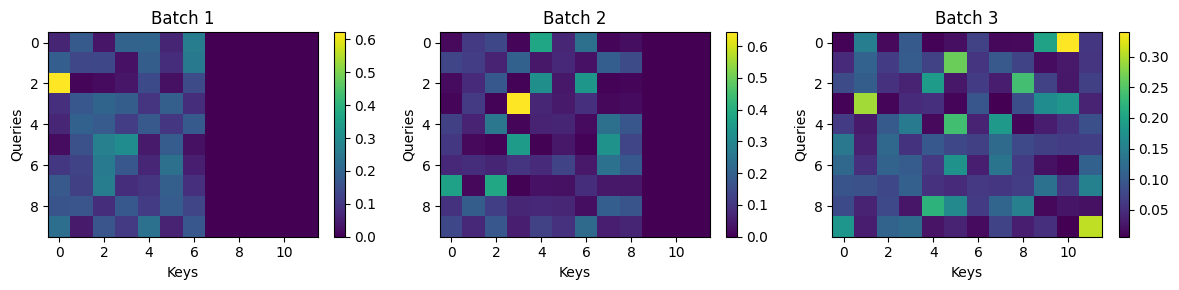

In [12]:
b, q, k = attention_weights.shape
fig, axes = plt.subplots(1, b, figsize=(4*b, 3))
if b == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    mat = attention_weights[i].detach().cpu().numpy()   # shape (num_queries, num_keys)
    im = ax.imshow(mat, cmap='viridis', aspect='auto', interpolation='nearest')
    ax.set_xlabel('Keys')
    ax.set_ylabel('Queries')
    ax.set_title(f'Batch {i+1}')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Attention Seq2Seq
Attention mechanisms can be effectively integrated into encoder-decoder architectures for sequence-to-sequence learning. Traditionally, in an RNN-based approach, all relevant information from the source sequence is encoded into a fixed-dimensional state representation by the encoder. However, rather than maintaining this state—represented by the context variable $\mathbf{c}$ that summarizes the source sentence—as a fixed value, it can be dynamically updated. This update is based on both the original text (encoder hidden states $\mathbf{h}_{t}$) and the previously generated text (decoder hidden states $\mathbf{s}_{t’-1}$). As a result, we obtain an updated context variable $\mathbf{c}_{t’}$ after each decoding time step $t’$. This approach allows the model to adapt the context dynamically, even for input sequences of length $T$, thereby improving the ability to handle long-range dependencies and capture more nuanced information from the source sequence.
In this case, the context variable is the output of attention pooling:

\begin{equation}
\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t'-1}, \mathbf{h}_t) \mathbf{h}_t.
\end{equation}

We used $\mathbf{s}_{t'-1}$ as the query, and $\mathbf{h}_t$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token.

### Question 5 [code] (10 points)
Implement the RNN decoder in the ``Seq2SeqAttentionDecoder`` class. The decoder’s state is initialized using three components: 

(i) the hidden states of the encoder’s last layer across all time steps, which are utilized as keys and values for the attention mechanism; 

(ii) the hidden state of the encoder’s final time step at all layers, which initializes the decoder’s hidden state; and 

(iii) the valid length of the encoder to exclude padding tokens during attention pooling. 

During each decoding time step, the hidden state of the decoder’s final layer from the previous step is used as the query for the attention mechanism. The attention mechanism’s output is then concatenated with the input embedding to form the input for the RNN decoder, effectively guiding the generation process with context from both the source sequence and previous decoder outputs.

Then, run the sanity check cell to check your implementation.

In [13]:
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps_enc, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps_enc, num_hiddens)
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps_dec, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        ### YOUR CODE HERE 
        for x in X: 
            # Hidden state of the decoder's final layer is used as the query
            query = hidden_state[-1].unsqueeze(1)  # Add a dimension to the hidden state so shape becomes (batch_size, 1, num_hiddens)
            # Attention step, computes a weighted combination of encoder outputs according to how similar query is to each key (enc_output)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens) 
            # Attention mechanism's output is concat with the input embedding to form the input for rnn decoder
            rnn_input = torch.cat((context, x.unsqueeze(1)), dim=-1)
            # Feed this combined information into the rnn, decoder updates its internal memory
            out, hidden_state = self.rnn(rnn_input.permute(1, 0, 2), hidden_state)
            outputs.append(out) # store the per-timestep output (word generated)
        # After finishing all steps, concat all the per-timestep outputs
        # Convert the decoder's internal representation into actual word predictions
        outputs = self.dense(torch.cat(outputs, dim=0))  # Apply a dense layer
        ### END OF YOUR CODE
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

In [14]:
# Sanity check
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size = 4
num_steps_enc = 5
num_steps_dec = 7

# instantiate encoder and decoder
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)

# dummy inputs
X_enc = torch.zeros((batch_size, num_steps_enc), dtype=torch.long)
X_dec = torch.zeros((batch_size, num_steps_dec), dtype=torch.long)

# initialize decoder state using encoder outputs
state = decoder.init_state(encoder(X_enc), None)

# forward pass through decoder
output, state = decoder(X_dec, state)

d2l.check_shape(output, (batch_size, num_steps_dec, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps_enc, num_hiddens))  # encoder outputs
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens)) # hidden_state
print("Pass!")

Pass!


## Multihead Attention
Rather than relying on a single attention pooling operation, the queries, keys, and values can be transformed through $h$ independently learned linear projections. These $h$ projected queries, keys, and values are then processed in parallel through attention pooling. Afterward, the $h$ resulting attention outputs, known as ``heads``, are concatenated and passed through another learned linear projection to generate the final output. This architecture, referred to as ``multi-head attention``, allows each attention head to focus on different parts of the input, enabling the model to capture a wider range of information.

![ma](Multihead_attention.png)

Given a query $\mathbf{q} \in \mathcal{R}^{d_q}$, a key $\mathbf{k} \in \mathcal{R}^{d_k}$, and a value $\mathbf{v} \in \mathcal{R}^{d_v}$, each attention head $\mathbf{h}_i$ $(i = 1, \ldots, h)$ is computed as:

\begin{equation}
\mathbf{h}_i = f(\mathbf{W}_i^{(q)} \mathbf{q}, \mathbf{W}_i^{(k)} \mathbf{k}, \mathbf{W}_i^{(v)} \mathbf{v}) \in \mathcal{R}^{p_v},
\end{equation}

where $\mathbf{W}_i^{(q)} \in \mathcal{R}^{p_q \times d_q}$, $\mathbf{W}_i^{(k)} \in \mathcal{R}^{p_k \times d_k}$, and $\mathbf{W}_i^{(v)} \in \mathcal{R}^{p_v \times d_v}$ are learnable parameters and $f$ is attention pooling. The multi-head attention output is another linear transformation via learnable parameters $\mathbf{W}_o \in \mathcal{R}^{p_o \times hp_v}$ of the concatenation of $h$ heads:

\begin{equation}
\mathbf{W}_o 
\begin{bmatrix}
\mathbf{h}_1 \\
\vdots \\
\mathbf{h}_h
\end{bmatrix}
\in \mathcal{R}^{p_o}. 
\end{equation}

Based on this design, each head may attend to different parts of the input. More sophisticated functions than the simple weighted average can be expressed.

### Question 6 [written] (10 points)
Please describe the benefits of using multi-head attention instead of single head attention.

- Since a wider range of information can be captured, more diverse and complex relationships can be learned, providing a more comprehensive understanding of the data.

- It would also increase the model's capacity to learn and represent complex data.

### Question 7 [code] (30 points)
In this implementation, we choose the scaled dot product attention for each head of the multi-head attention. To avoid significant growth of computational cost and parameterization cost, we set $p_q = p_k = p_v = p_o / h$. Note that $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_qh = p_kh = p_vh = p_o$. In the following implementation, $p_o$ is specified via the argument ``num_hiddens``.


To allow for parallel computation of multiple heads, the ``MultiHeadAttention`` class uses two transposition methods ``transpose_qkv`` and ``transpose_output``. Specifically, the ``transpose_output`` method reverses the operation of the ``transpose_qkv`` method.

**Question 7.1 [code] (10 points)** Implement function ``transpose_qkv``, which is the transposition for parallel computation of multiple attention heads.

**Question 7.2 [code] (10 points)** Implement function ``transpose_output`` that reverse the operation of ``transpose_qkv``.

**Question 7.3 [code] (10 points)**
Complete `MultiHeadAttention` class. (Hint: you can use the two function you defined in question 7.1 and 7.2 .)


💡 **Hints:**
You may find the following functions helpful (but you are not required to use them):
- `torch.repeat_interleave`
- `torch.reshape`
- `torch.permute`

In [15]:
class MultiHeadAttention(nn.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, num_queries)
        
        ### YOUR CODE HERE
        # Project queries, keys and values through linear layers and transpose
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        # Adjust valid lens for multiple heads
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # Process in parallel through attention pooling
        output = self.attention(queries, keys, values, valid_lens)
        # Resulting heads are concatenated and passed through another learned linear projection to generate the final output
        output_concat = self.transpose_output(output)
        ### END OF YOUR CODE
        return self.W_o(output_concat)
    
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of X: (batch_size, no. of queries or key-value pairs, num_hiddens)

        ### YOUR CODE HERE
        batch_size, num_queries, num_hiddens = X.shape
        num_heads=self.num_heads
        X = torch.reshape(X,(batch_size*num_heads, num_queries, num_hiddens//num_heads))
        return X
        # Shape of output: (batch_size*num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        ### END OF YOUR CODE

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        # Shape of X: (batch_size * num_heads, num_queries, num_hiddens / num_heads)
        ### YOUR CODE HERE
        batchsize_times_numheads, seq_len, numhiddens_div_numheads = X.shape
        num_heads=self.num_heads
        batch_size = batchsize_times_numheads // num_heads
        num_hiddens = numhiddens_div_numheads * num_heads
        X = torch.reshape(X,(batch_size, seq_len,num_hiddens))
        return X
        # Shape of output: (batch_size, seq_len, num_hiddens)
        ### END OF YOUR CODE

In [16]:
# sanity check
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 6])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))
print("Pass!")

Pass!
